In [1]:
# Unzip 
# !unzip Q4_dataset.zip 

In [2]:
# Import packages
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import os
import random
from collections import Counter

In [3]:
# Switch to dataset directory
os.chdir("/content/drive/MyDrive/ECE2/ECE6780/Programming/MedNIST_dataset")

## a) Load data

In [4]:
classes = sorted(os.listdir()) # Get sorted list of classes
X_train = []; Y_train = []
X_test = []; Y_test = []

for idx, folder in enumerate(classes):
    print(idx,"/",len(classes))
    img_list = random.sample(os.listdir(folder),1000) # choose 1000 random images without replacement

    # Train-test split: 70:30
    for img in img_list[:700]: # 700 each for train
        im = plt.imread(os.path.join(folder,img))
        im = im/np.max(im) # normalize
        X_train.append(im)
        Y_train.append(idx)

    for img in img_list[700:]: # 300 each for test
        im = plt.imread(os.path.join(folder,img))
        im = im/np.max(im) # normalize
        X_test.append(im)
        Y_test.append(idx)

X_train = np.expand_dims(X_train,1)
X_test = np.expand_dims(X_test,1)

0 / 6
1 / 6
2 / 6
3 / 6
4 / 6
5 / 6


In [5]:
# Prepare train and test sets, along with their loaders
trainset = TensorDataset(torch.Tensor(X_train),torch.Tensor(Y_train)) 
trainloader = DataLoader(trainset, shuffle = True, batch_size = 16)

testset = TensorDataset(torch.Tensor(X_test),torch.Tensor(Y_test)) 
testloader = DataLoader(testset, batch_size = 16)

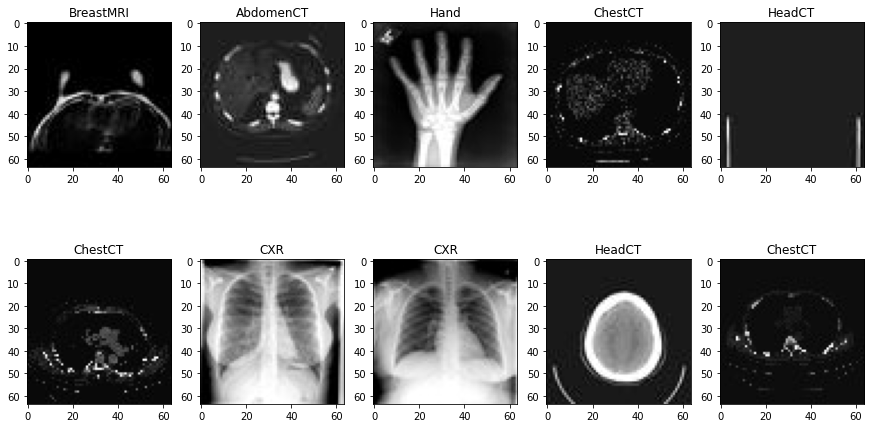

In [17]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show 10 images
plt.figure(figsize=(15,8))
for n in range(10):
    plt.subplot(2,5,n+1)
    im = images[n]
    plt.imshow(im[0], "gray")
    plt.title(classes[int(labels[n])]) # Show labels as titles


## b) Network

In [7]:
model = nn.Sequential(
          nn.Conv2d(1,20,5), # First conv block
          nn.ReLU(),
          nn.MaxPool2d(2,2),

          nn.Conv2d(20,64,5), # Second conv block
          nn.ReLU(),
          nn.MaxPool2d(2,2),

          nn.Flatten(), # Flatten to feed into FC layers
          nn.Linear(10816,100), # FC1
          nn.ReLU(),
          nn.Linear(100,60), # FC2
          nn.ReLU(),
          nn.Linear(60,6) # FC3, outputs raw scores for the 6 classes
          
        )

print(model) # Show model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(20, 64, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=10816, out_features=100, bias=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=60, bias=True)
  (10): ReLU()
  (11): Linear(in_features=60, out_features=6, bias=True)
)


## c) Train and Test

In [8]:
criterion = nn.CrossEntropyLoss() # CE Loss, Takes care of applying softmax
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Adam optimizer

In [9]:
train_loss_list = []
test_loss_list = []

for epoch in range(10):  # 10 epochs
    
    # Training
    model.train() # Set to train mode
    running_loss = 0.0
    running_corrects = 0

    for i, data in enumerate(trainloader): # Get data batch-wise
        inputs, labels = data
        labels = labels.type(torch.LongTensor)

        # zero out gradients
        optimizer.zero_grad()

        outputs = model(inputs) # forward pass
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels) # Get loss
        loss.backward() # Backward pass
        optimizer.step() # Optimize model weights

        _, preds = torch.max(outputs, 1) # Get predictions
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    # Get loss and accuracy
    train_loss = (running_loss / len(trainset))
    train_loss_list.append(train_loss)
    train_accuracy = (running_corrects.float() / len(trainset))

    # Testing
    model.eval() # Set to eval mode
    running_loss = 0.0
    running_corrects = 0
    y = []; yhat = []

    for i, data in enumerate(testloader):
        inputs, labels = data
        labels = labels.type(torch.LongTensor)

        # forward + backward + optimize
        with torch.no_grad(): # Don't build computation graph for testing
            outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        y.append(labels.tolist())
        yhat.append(preds.tolist())
        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    # Get loss and accuracy
    test_loss = (running_loss / len(testset))
    test_loss_list.append(test_loss)
    test_accuracy = (running_corrects.float() / len(testset))

    # Display loss, accuracy values after each epoch
    print("Epoch:{} Train loss: {:.4f} Test loss: {:.4f} Train acc.: {:.4f} Test acc.: {:.4f}\n"
              .format(epoch, train_loss.item(),test_loss.item(),train_accuracy.item(),test_accuracy.item()))


Epoch:0 Train loss: 0.5191 Test loss: 0.1961 Train acc.: 0.8393 Test acc.: 0.9656

Epoch:1 Train loss: 0.3869 Test loss: 0.4135 Train acc.: 0.8600 Test acc.: 0.7972

Epoch:2 Train loss: 0.3523 Test loss: 0.2271 Train acc.: 0.8924 Test acc.: 0.9444

Epoch:3 Train loss: 0.2112 Test loss: 0.1060 Train acc.: 0.9462 Test acc.: 0.9772

Epoch:4 Train loss: 0.1702 Test loss: 0.1502 Train acc.: 0.9602 Test acc.: 0.9733

Epoch:5 Train loss: 0.1033 Test loss: 0.0954 Train acc.: 0.9738 Test acc.: 0.9817

Epoch:6 Train loss: 0.0890 Test loss: 0.1791 Train acc.: 0.9714 Test acc.: 0.9767

Epoch:7 Train loss: 0.1894 Test loss: 0.1160 Train acc.: 0.9648 Test acc.: 0.9661

Epoch:8 Train loss: 0.1652 Test loss: 0.1577 Train acc.: 0.9669 Test acc.: 0.9783

Epoch:9 Train loss: 0.0413 Test loss: 0.0517 Train acc.: 0.9888 Test acc.: 0.9878



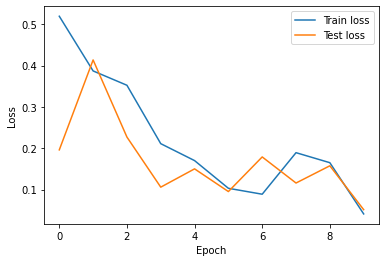

In [10]:
# Loss curves
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

## d) Performance metrics

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
def flatten(t): # flatten into a single list
    return [item for sublist in t for item in sublist]

y = flatten(y)
yhat = flatten(yhat)

In [13]:
# Print precision, recall , F1 score for each class and overall accuracy
print(classification_report(y, yhat, target_names=classes, digits=4))

              precision    recall  f1-score   support

   AbdomenCT     0.9901    1.0000    0.9950       300
   BreastMRI     0.9967    0.9967    0.9967       300
         CXR     0.9706    0.9900    0.9802       300
     ChestCT     0.9901    0.9967    0.9934       300
        Hand     0.9896    0.9500    0.9694       300
      HeadCT     0.9900    0.9933    0.9917       300

    accuracy                         0.9878      1800
   macro avg     0.9878    0.9878    0.9877      1800
weighted avg     0.9878    0.9878    0.9877      1800



In [14]:
# Overall accuracy: 0.9878

In [15]:
# Confusion matrix, classes are in sorted order like before
print(confusion_matrix(y,yhat))

[[300   0   0   0   0   0]
 [  0 299   0   0   0   1]
 [  0   0 297   0   3   0]
 [  1   0   0 299   0   0]
 [  2   1   9   1 285   2]
 [  0   0   0   2   0 298]]


"Hand" was most difficult to learn as it has lower recall and f1-score values compared to other classes as well as more misclassified instances in the confusion matrix.